In [272]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import scipy.cluster.hierarchy as sch
import seaborn as sns
df_global = pd.read_csv('../Data/global.csv', encoding='ISO-8859-1')
df_without_norm = pd.read_csv('../Data/global_preprocessed_without_onehot_and_norm.csv')
df = pd.read_csv('../Data/global_preprocessed_without_onehot.csv', encoding='ISO-8859-1')
#df_without_norm = df_without_norm[:df_without_norm.shape[0]//10]
#df = df[:df.shape[0]//10]

dfh = df.sample(frac=0.1)
df_without_normh = df_without_norm[:df_without_norm.shape[0]//10]
#df = df[:df.shape[0]//10]
#df_without_norm = df_without_norm[:df_without_norm.shape[0]//10]

C:\Users\Admin\AppData\Local\Temp\ipykernel_5912\3402666694.py:9: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df_global = pd.read_csv('../Data/global.csv', encoding='ISO-8859-1')


In [273]:
df_global.rename(columns={'gname': 'gname_txt'}, inplace=True)
df_global['gname'] = pd.factorize(df_global['gname_txt'])[0]
attacktype_dict = dict(zip(df_global['attacktype1'], df_global['attacktype1_txt']))
targettype_dict = dict(zip(df_global['targtype1'], df_global['targtype1_txt']))
region_dict = dict(zip(df_global['region'], df_global['region_txt']))
gname_dict = dict(zip(df_global['gname'], df_global['gname_txt']))

In [274]:
df

,iyear,extended,region,nkill,nwound,attacktype1,nperps,suicide,success,gname,individual,targtype1
0,-2.952239,0,2,0.095379,0.000000,1,-0.048337,0,1,0,0,14
1,-2.952239,0,1,0.000000,0.000000,6,0.290024,0,1,1,0,7
2,-2.952239,0,5,0.095379,0.000000,1,-0.048337,0,1,2,0,10
3,-2.952239,0,8,0.000000,0.000000,3,-0.048337,0,1,2,0,7
4,-2.952239,0,4,0.000000,0.000000,7,-0.048337,0,1,2,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
171275,0.605588,0,11,0.095379,0.056697,2,0.000000,0,1,2656,0,4
171276,0.605588,0,10,0.190758,0.198440,3,0.000000,0,1,592,0,4
171277,0.605588,0,5,0.000000,0.000000,7,0.000000,0,1,2926,0,14
171278,0.605588,0,6,0.000000,0.000000,3,0.000000,0,0,2,0,2


GridSearch for KMeans clustering

In [275]:
# Define the parameter grid
k_values = range(4, 15)   

# Store silhouette scores and k values
silhouette_scores = []
k_values_used = []
kmeans_array = []
# Perform "Grid Search"
for k in k_values:
    print("K: " + str(k))
    kmeans_i = KMeans(n_clusters=k, random_state=0, n_init='auto', max_iter=100)
    kmeans_i.fit(df)
    score = silhouette_score(df, kmeans_i.labels_,  sample_size=1000)
    silhouette_scores.append(score)
    kmeans_array.append(kmeans_i)
    k_values_used.append(k)

K: 4
K: 5
K: 6
K: 7
K: 8
K: 9
K: 10
K: 11
K: 12
K: 13
K: 14


Best k: 4


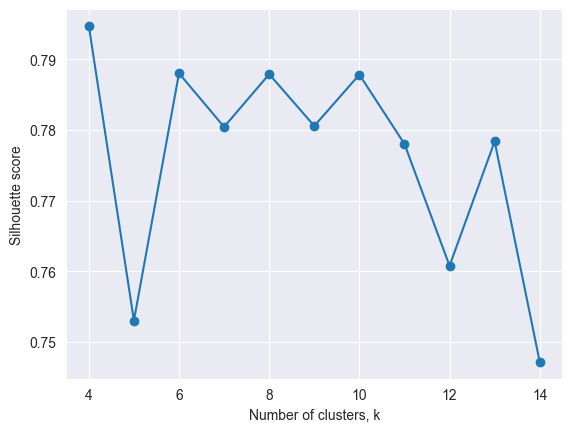

In [276]:
# Determine the best k
best_k = k_values_used[silhouette_scores.index(max(silhouette_scores))]
kmeans = kmeans_array[silhouette_scores.index(max(silhouette_scores))]
print('Best k:', best_k)

# Plot
plt.plot(k_values_used, silhouette_scores, marker='o')
plt.xlabel("Number of clusters, k")
plt.ylabel("Silhouette score")
plt.show()

In [277]:
df['KMeans_labels'] = kmeans.labels_
df_without_norm['KMeans_labels'] = kmeans.labels_

In [278]:
eps_vals = np.linspace(0.3, 1.7, 4)
min_samples_vals = [10]

best_score = -1
best_eps = None
best_dbscan = None
best_min_samples = None


GridSearch for DBSCAN clustering

In [279]:
# DBSCAN clustering
for eps in eps_vals:
    print("Eps: " + str(eps))
    for min_samples in min_samples_vals:
        print("Min samples: " + str(min_samples))
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        
        # Fit the model
        labels = dbscan.fit_predict(df)
        
        # Ignore cases where the clustering resulted in only one cluster or noise
        if len(np.unique(labels)) > 1:
            score = silhouette_score(df, labels, sample_size=1000)
            
            # If the silhouette score is better, store these parameters as the best
            if score > best_score:
                best_dbscan = dbscan
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

Eps: 0.3
Min samples: 10
Eps: 0.7666666666666666
Min samples: 10
Eps: 1.2333333333333332
Min samples: 10
Eps: 1.7
Min samples: 10


Best params for DBSCAN clustering

In [280]:
print("Best eps: " + str(best_eps))
print("Best score: " + str(best_score))
print("Best min samples: " + str(best_min_samples))

Best eps: 1.7
Best score: 0.16589215080932296
Best min samples: 10


In [281]:
dbscan = best_dbscan
df['DBSCAN_labels'] = dbscan.labels_
df_without_norm['DBSCAN_labels'] = dbscan.labels_

Hierarchical clustering

In [282]:
try:
    # Hierarchical clustering
    agg_clustering = AgglomerativeClustering(n_clusters=best_k)
    agg_clustering.fit(dfh)
    dfh['Hierarchical_labels'] = agg_clustering.labels_
    df_without_normh['Hierarchical_labels'] = agg_clustering.labels_
except:
    pass

C:\Users\Admin\AppData\Local\Temp\ipykernel_5912\2421614822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_normh['Hierarchical_labels'] = agg_clustering.labels_


Evaluation of KMeans, DBSCAN and Hierarchical models

In [283]:
print(f"KMeans silhouette score: {silhouette_score(df, kmeans.labels_, sample_size=1000):.2f}")
print(f"DBSCAN silhouette score: {silhouette_score(df, dbscan.labels_, sample_size=1000):.2f}")
try:
    print(f"Hierarchical silhouette score: {silhouette_score(dfh, agg_clustering.labels_, sample_size=1000):.2f}")
except:
    pass

KMeans silhouette score: 0.74
DBSCAN silhouette score: 0.29
Hierarchical silhouette score: 0.76


In [284]:
# Comparison with true labels
#print(f"KMeans Adjusted Rand Index: {adjusted_rand_score(df, df['KMeans_labels']):.2f}")
#print(f"DBSCAN Adjusted Rand Index: {adjusted_rand_score(df, df['DBSCAN_labels']):.2f}")
#print(f"Hierarchical Adjusted Rand Index: {adjusted_rand_score(df, df['Hierarchical_labels']):.2f}")

KMeans clusters

In [285]:
df_KMeans = df_without_norm.copy()
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_KMeans.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_KMeans = pd.merge(df_KMeans, mode_df, on='KMeans_labels', how='left')
    df_KMeans.drop(label + '_x', axis=1, inplace=True)
    df_KMeans.rename(columns={label + '_y': label}, inplace=True)

In [286]:
df_KMeans = df_KMeans.groupby("KMeans_labels").mean()
df_KMeans["targtype1"] = df_KMeans['targtype1'].map(targettype_dict)
df_KMeans["region"] = df_KMeans['region'].map(region_dict)
df_KMeans["gname"] = df_KMeans['gname'].map(gname_dict)
df_KMeans["attacktype1"] = df_KMeans['attacktype1'].map(attacktype_dict)
df_KMeans

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,DBSCAN_labels,attacktype1,targtype1,region,gname
KMeans_labels,,,,,,,,,,,,,
0,2013.623799,0.097562,4.158115,4.318122,4.305968,0.101274,0.902220,0.001383,527.762846,Bombing/Explosion,Private Citizens & Property,Middle East & North Africa,Jaljala Army
1,2000.383015,0.029533,1.379758,2.266119,2.011420,0.021008,0.877945,0.002481,25.312908,Bombing/Explosion,Private Citizens & Property,Middle East & North Africa,Unknown
2,1996.470704,0.034076,2.091655,2.504161,4.078610,0.007816,0.918803,0.006129,226.680612,Bombing/Explosion,Private Citizens & Property,South Asia,Arab Revenge Organization
3,2007.359330,0.090921,3.930721,5.638889,5.094814,0.056611,0.899710,0.006532,361.254619,Bombing/Explosion,Private Citizens & Property,South Asia,Association of Demobilized Armed Forces


In [287]:
df_extended = df_without_norm.copy()
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_extended.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_extended = pd.merge(df_extended, mode_df, on='KMeans_labels', how='left')
    df_extended.drop(label + '_x', axis=1, inplace=True)
    df_extended.rename(columns={label + '_y': label}, inplace=True)

Showing extended/not extended classes

In [288]:
df_extended = df_extended.groupby("extended").mean()
df_extended["targtype1"] = df_extended['targtype1'].map(targettype_dict)
df_extended["region"] = df_extended['region'].map(region_dict)
df_extended["gname"] = df_extended['gname'].map(gname_dict)
df_extended["attacktype1"] = df_extended['attacktype1'].map(attacktype_dict)
df_extended

,iyear,nkill,nwound,nperps,suicide,success,individual,KMeans_labels,DBSCAN_labels,attacktype1,targtype1,region,gname
extended,,,,,,,,,,,,,
0,2002.454430,2.096430,2.999786,2.73117,0.037106,0.882797,0.003153,1.122045,152.379445,Bombing/Explosion,Private Citizens & Property,NaN,NaN
1,2008.150523,2.716211,1.246127,5.66230,0.006046,0.995214,0.000756,1.085779,242.570097,Bombing/Explosion,Private Citizens & Property,NaN,NaN


In [289]:
df_attack = df_without_norm.copy()
df_attack["attacktype1"] = df_attack['attacktype1'].map(attacktype_dict)
for label in ["targtype1", "region", "gname"]:    
    mode_df = df_attack.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_attack = pd.merge(df_attack, mode_df, on='KMeans_labels', how='left')
    df_attack.drop(label + '_x', axis=1, inplace=True)
    df_attack.rename(columns={label + '_y': label}, inplace=True)

Showing classes by attack type

In [290]:
df_attack = df_attack.groupby("attacktype1").mean()
df_attack["targtype1"] = df_attack['targtype1'].map(targettype_dict)
df_attack["region"] = df_attack['region'].map(region_dict)
df_extended["gname"] = df_extended['gname'].map(gname_dict)
df_attack

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,KMeans_labels,DBSCAN_labels,targtype1,region,gname
attacktype1,,,,,,,,,,,,,
Armed Assault,2003.688304,0.012342,3.518513,1.872133,5.380264,0.001271,0.944727,0.004529,1.199269,181.435802,Private Citizens & Property,NaN,878.325759
Assassination,1996.199810,0.005905,1.290120,0.720055,1.094739,0.013707,0.756590,0.001845,1.155789,97.414488,Private Citizens & Property,NaN,439.037168
Bombing/Explosion,2003.643343,0.001280,1.722058,4.248537,1.348494,0.067554,0.877236,0.001540,1.061737,146.242554,Private Citizens & Property,NaN,665.439625
Facility/Infrastructure Attack,2000.636728,0.007517,0.337108,0.350874,4.086108,0.000098,0.943962,0.008982,1.158743,138.573465,Private Citizens & Property,NaN,755.876989
Hijacking,1999.171733,0.226444,5.650456,25.837386,4.724924,0.016717,0.878419,0.030395,1.189970,119.978723,Private Citizens & Property,NaN,882.977204
Hostage Taking (Barricade Incident),1994.939919,0.109980,4.532587,4.031568,11.785132,0.054990,0.991853,0.017312,1.188391,119.390020,Private Citizens & Property,NaN,890.223014
Hostage Taking (Kidnapping),2005.433651,0.632003,1.981017,0.544402,4.636077,0.002685,0.977683,0.000926,1.071859,220.519863,Private Citizens & Property,NaN,1258.240763
Unarmed Assault,2003.839104,0.002037,0.872709,13.908350,5.232179,0.002037,0.869654,0.045825,1.466395,144.927699,Private Citizens & Property,NaN,919.639511
Unknown,2004.234886,0.014189,4.233498,1.980568,6.414559,0.000308,0.832665,0.000154,1.270820,252.021437,Private Citizens & Property,NaN,1392.418877


DBSCAN clusters

In [291]:
df_DBSCAN = df_without_norm.copy()

In [292]:
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_DBSCAN.groupby('DBSCAN_labels')[label].agg(pd.Series.mode).reset_index()
    df_DBSCAN = pd.merge(df_DBSCAN, mode_df, on='DBSCAN_labels', how='left')
    df_DBSCAN.drop(label + '_x', axis=1, inplace=True)
    df_DBSCAN.rename(columns={label + '_y': label}, inplace=True)

In [293]:
df_DBSCAN = df_DBSCAN.groupby("DBSCAN_labels").mean(numeric_only=False)
#df_DBSCAN["targtype1"] = df_DBSCAN['targtype1'].map(targettype_dict)
#df_DBSCAN["region"] = df_DBSCAN['region'].map(region_dict)
#df_DBSCAN["gname"] = df_DBSCAN['gname'].map(gname_dict)
#df_DBSCAN["attacktype1"] = df_DBSCAN['attacktype1'].map(attacktype_dict)
df_DBSCAN

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,KMeans_labels,attacktype1,targtype1,region,gname
DBSCAN_labels,,,,,,,,,,,,,
-1,1997.543921,0.091995,6.053473,8.083169,14.020195,0.035251,0.907902,0.012823,1.341605,3.0,14.0,6.0,2.0
0,2005.064793,0.029028,1.190273,2.361631,0.970683,0.027403,0.864105,0.001637,1.000000,3.0,14.0,10.0,2.0
1,1970.798450,0.007752,0.054264,0.100775,0.852713,0.000000,0.713178,0.000000,1.000000,3.0,1.0,1.0,7.0
2,1970.323529,0.000000,0.000000,0.014706,1.161765,0.000000,0.897059,0.000000,1.000000,7.0,2.0,1.0,7.0
3,1975.483871,0.000000,0.774194,0.290323,1.096774,0.000000,0.903226,0.483871,1.000000,2.0,14.0,1.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,2017.000000,0.000000,0.000000,0.000000,200.000000,0.000000,1.000000,0.000000,2.000000,2.0,14.0,6.0,1106.0
853,2017.000000,0.000000,0.000000,0.000000,1.175000,0.000000,1.000000,0.000000,0.000000,7.0,2.0,6.0,3432.0
854,2017.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,7.0,19.0,8.0,3434.0


Hierarc clusters

In [294]:
try:
    df_Hierarc = df_without_normh
    for label in ["attacktype1", "targtype1", "region", "gname"]:    
        mode_df = df_Hierarc.groupby('Hierarchical_labels')[label].agg(pd.Series.mode).reset_index()
        df_Hierarc = pd.merge(df_Hierarc, mode_df, on='Hierarchical_labels', how='left')
        df_Hierarc.drop(label + '_x', axis=1, inplace=True)
        df_Hierarc.rename(columns={label + '_y': label}, inplace=True)
except:
    pass

In [295]:
try:
    df_Hierarc = df_Hierarc.groupby("Hierarchical_labels").mean(numeric_only=False)
    df_Hierarc["targtype1"] = df_Hierarc['targtype1'].map(targettype_dict)
    df_Hierarc["region"] = df_Hierarc['region'].map(region_dict)
    df_Hierarc["gname"] = df_Hierarc['gname'].map(gname_dict)
    df_Hierarc["attacktype1"] = df_Hierarc['attacktype1'].map(attacktype_dict)
    #print(df_Hierarc)
except:
    pass
df_Hierarc

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,attacktype1,targtype1,region,gname
Hierarchical_labels,,,,,,,,,,,,
0,1978.186518,0.024101,0.926650,1.002096,2.658750,0.000000,0.903248,0.001746,Bombing/Explosion,Business,Western Europe,Unknown
1,1978.291833,0.021053,0.861343,1.235935,1.705263,0.000000,0.907078,0.001452,Bombing/Explosion,Business,Western Europe,Unknown
2,1978.195964,0.019887,0.997866,1.061021,2.188785,0.000097,0.903958,0.002716,Bombing/Explosion,Business,Western Europe,Unknown
3,1978.174709,0.017471,0.982529,0.742097,2.861065,0.000000,0.911814,0.004160,Bombing/Explosion,Business,Western Europe,Unknown


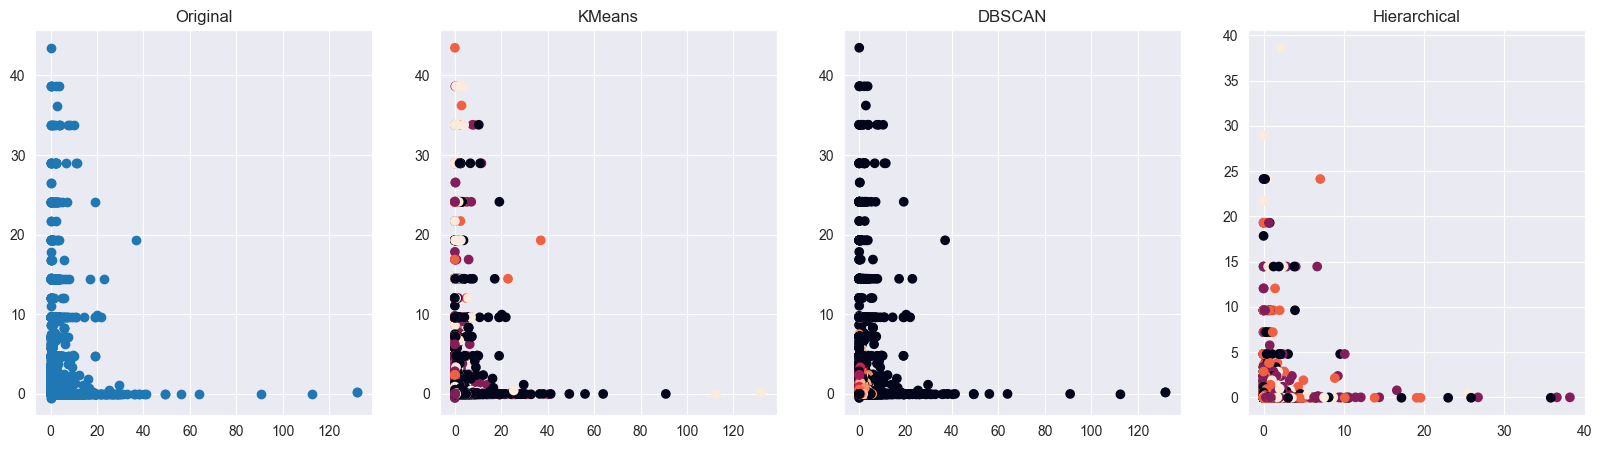

In [296]:

# Visualization
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].scatter(df['nkill'], df['nperps'])
ax[0].set_title('Original')

ax[1].scatter(df['nkill'], df['nperps'], c=df['KMeans_labels'])
ax[1].set_title('KMeans')

ax[2].scatter(df['nkill'], df['nperps'], c=df['DBSCAN_labels'])
ax[2].set_title('DBSCAN')
try:
    ax[3].scatter(dfh['nkill'], dfh['nperps'], c=dfh['Hierarchical_labels'])
    ax[3].set_title('Hierarchical')
except:
    pass
plt.show()


In [ ]:
sns.pairplot(df, hue='KMeans_labels')
sns.pairplot(dfh, hue='Hierarchical_labels')


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x00000252D5DCDEA0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [ ]:
corr = df.corr()

# Cluster
d = sch.distance.pdist(corr)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')

columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df_clustered = df.reindex(columns, axis=1)

# Draw clustered heatmap
sns.clustermap(df_clustered.corr(), cmap='coolwarm', annot=True, linewidths=.1)

In [ ]:
print(len(set(df['KMeans_labels'])), len(set(df['DBSCAN_labels'])), len(set(dfh['Hierarchical_labels'])))